# The language of Orbicide lyrics

Orbicide lyrics are supposed to refer to the Bible. But is it visibly reflected in the language? What does Jacek really sing about?

Here is a simple text mining exercise attempting to reveal which words are most characteristic of **Orbicide** lyrics.

![Orbicide band photo](http://orbicide.org/wp-content/uploads/2017/08/IMG_0001.jpg)

More about the band: http://orbicide.org • http://fb.com/orbicide

## Preparation: read lyrics from website

In [1]:
lyrics_url = 'http://orbicide.org/lyrics/'

In [2]:
import requests
import bs4
resp = requests.get(lyrics_url)
resp.raise_for_status()
soup = bs4.BeautifulSoup(resp.content, 'html.parser')

In [3]:
def texts(root_node, unwanted_ids, stop_texts):
    if type(root_node) is bs4.element.Tag:
        #print(root_node.get('id'))
        if root_node.get('id') not in unwanted_ids:
            for node in root_node:
                yield from texts(node, unwanted_ids, stop_texts)
    elif type(root_node) is bs4.element.NavigableString:
        text = str(root_node).strip()
        if text and text.lower() not in stop_texts:
            yield text

In [4]:
article = soup.find('article')
verses = list(texts(article, ['toc_container', 'comments', 'secondary'], ['lyrics']))

## Perform lemmatisation and filtering of punctuation

In [5]:
# load spacy English model
import spacy
nlp = spacy.load('en_depent_web_md')

In [6]:
from nltk.probability import FreqDist

def lemma_of(tok):
    if tok.pos_ == 'PUNCT' or not tok.orth_.isalpha():
        return None
    if tok.lemma_.startswith('-'):
        return tok.orth_.lower()
    return tok.lemma_

def normalise(text):
    return ' '.join(text.split())

def tokenise(text):
    par = nlp(normalise(text))
    words = [lemma_of(tok) for tok in par]
    return [w for w in words if w]

def wdist(texts):
    words = [w for text in texts for w in tokenise(text)]
    return FreqDist(words)

def total(dist):
    """Sum of all occurrences."""
    return sum(dist.values())

## Most frequent lemmas in Orbicide lyrics

In [7]:
lyric_dist = wdist(verses)

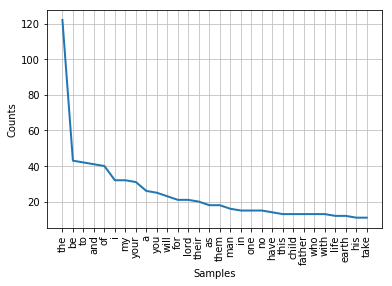

In [8]:
lyric_dist.plot(30)

Most of the most frequent words are function words (determiners, prepositions, pronouns), which is typical of any text. What is interesting is high frequency of 1st and 2nd person personal and possesive pronouns (I, my, you, your). Also, the word _lord_ ranked 12th most common gives a hint about the topic.

## Compare vocabulary of Orbicide lyrics to general English

Let's use text from the Brown corpus as an approximation of ‘general English’.

In [9]:
import nltk
#nltk.download('brown')

def prespace(form):
    """Quick and dirty way of adding spaces preceding non-punct tokens."""
    if form in '.,;:)`]':
        return form
    return ' ' + form

def back_to_text(forms):
    return ''.join(prespace(form) for form in forms)

brown_all_sents = [back_to_text(sent) for sent in nltk.corpus.brown.sents()]

In [10]:
bdist = wdist(brown_all_sents)

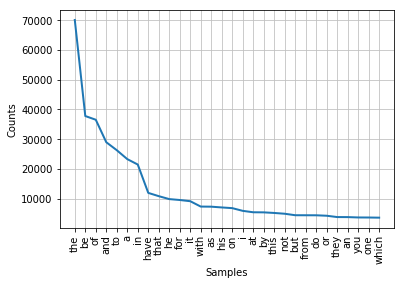

In [11]:
# most frequent words in Brown corpus
bdist.plot(30)

### Log-likelihood as a measure of vocabulary differences

The log-likelihood ratio allows to answer the question how significant is the difference between frequency of a word W in corpora A and B (here: Jacek's lyrics written for Orbicide and the whole Brown corpus).

High values of the score mean that the difference is significant, whether the form is more frequent in A or in B. To get forms typical for A, we need to limit the top-ranked words to those that are more frequent in A.

Read more: http://wordhoard.northwestern.edu/userman/analysis-comparewords.html

Log-likelihood ratio can only work for words presend in both corpora. Here I'm using a simple modification: a simple “smoothing” technique that each word from both corpora has appeared one more time in both of them than in fact it did (this is to make missing words appear once).

In [12]:
import math

def rel_freq(word, dist):
    return dist[word] / total(dist)

def log_likelihood_score(word, my_dist, their_dist):
    a = my_dist[word]
    b = their_dist[word]
    c = total(my_dist)
    d = total(their_dist)
    e1 = c*(a+b)/(c+d)
    e2 = d*(a+b)/(c+d)
    return 2.0 * ((a * math.log(a / e1)) + (b * math.log(b / e2)))

def smooth(dist1, dist2):
    """Return "smoothed" variants of both distributions.
    Each distribution will feature all words from both. Each word count is increased by 1."""
    new_dist1 = dist1.copy()
    new_dist2 = dist2.copy()
    all_words = set(dist1.keys()) | set(dist2.keys())

    for key in all_words:
        new_dist1[key] += 1
        new_dist2[key] += 1
    
    return new_dist1, new_dist2

def ll_ranking(my_dist, their_dist):
    """Log-likelihood ratio ranking. Returns (score, word, here/there ratio)."""
    items = []
    for word in my_dist:
        if word in their_dist:
            score = log_likelihood_score(word, my_dist, their_dist)
            items.append((score, word, rel_freq(word, my_dist) / rel_freq(word, their_dist)))
    return sorted(items, reverse=True)

def ll_ranking_smoothed(my_dist, their_dist):
    """Log-likelihood with smoothing."""
    items = []
    my_dist, their_dist = smooth(my_dist, their_dist)
    all_words = set(my_dist.keys()) | set(their_dist.keys())
    for word in all_words:
        score = log_likelihood_score(word, my_dist, their_dist)
        items.append((score, word, rel_freq(word, my_dist) / rel_freq(word, their_dist)))
    return sorted(items, reverse=True)

def ll_ranking_smoothed_here(my_dist, their_dist):
    ranking = ll_ranking_smoothed(my_dist, their_dist)
    return [(score, word, ratio) for (score, word, ratio) in ranking if ratio > 1.0]

In [13]:
ll_ranking = ll_ranking_smoothed_here(lyric_dist, bdist)[:50]

In [17]:
import pandas as pd
pd.DataFrame(ll_ranking, columns=['LL ratio', 'Word', 'Freq ratio'])

,LL ratio,Word,Freq ratio
0,55.387791,orbicide,270.188333
1,42.122480,smite,210.146482
2,42.122480,omnicide,210.146482
3,40.296977,lord,6.172527
4,36.064586,cleanse,70.048827
5,35.539850,firstborn,180.125556
6,29.005420,ov,150.104630
7,29.005420,nagila,150.104630
8,29.005420,hava,150.104630
9,26.101915,willfully,75.052315


The ranking contains mush less function words. The only possisive pronoun present above is ‘thy’.

The vocabulary clearly refers to biblical topics (such as _lord_, _transgress_, _Sodom_, _Gomorrah_, _blessing_, _altar_). Perhaps words refering to murder, destruction and other forms of violence are even more evident (not unlike in Bible itself; _smite_, _plunder_, _persecutor_, _genocide_, _rape_).

## Draw a word cloud

Let size of each word indicate its log-likelihood score. In other words — the larger the word, the more characteristic it is of Orbicide lyrics (as opposed to standard English)

In [15]:
word_rating = {e[1]: e[0] for e in ll_ranking}

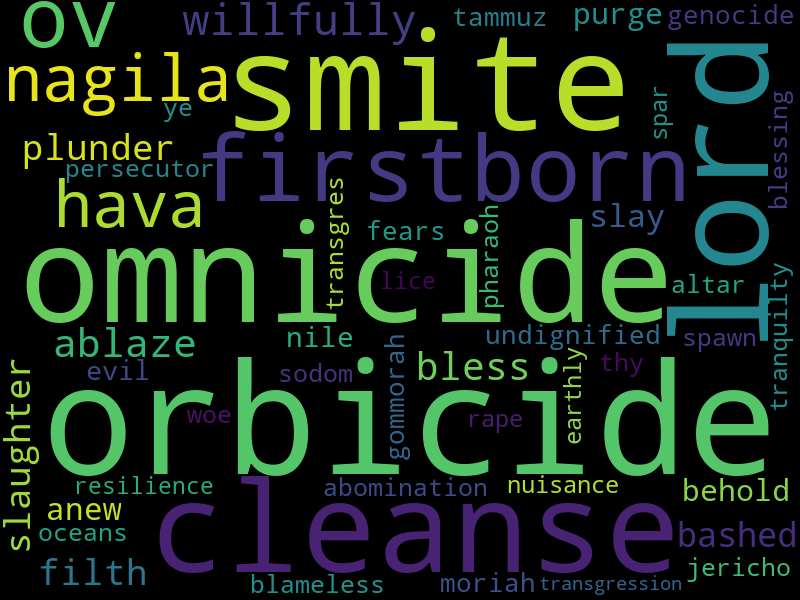

In [16]:
import wordcloud
wordcloud.WordCloud(
    #background_color="white",
    collocations=False, width=800, height=600,
    ).generate_from_frequencies(
    word_rating).to_image()